In [ ]:
!pip install nsepy

In [ ]:
import pandas as pd
import numpy as np
 
# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)
 
# install the nsepy library to get stock prices

 
############################################
# Getting Stock data using nsepy library
from nsepy import get_history
from datetime import datetime
 
startDate=datetime(2019, 1,1)
endDate=datetime(2020, 10, 5)
StockData = pd.read_csv('Future5_HDFC.csv')
 
# Fetching the data
#StockData=get_history(symbol='INFY', start=startDate, end=endDate)
print(StockData.shape)
StockData.head()
StockData.tail()

(363, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
358,6/4/2021,76.599998,76.860001,76.209999,76.839996,76.839996,361800
359,6/7/2021,76.570000,77.070000,76.559998,76.919998,76.919998,490700
360,6/8/2021,76.500000,77.000000,76.300003,76.949997,76.949997,890400
361,6/9/2021,76.650002,77.620003,76.459999,77.250000,77.250000,1164600
362,6/10/2021,77.239998,77.449997,76.500000,77.239998,77.239998,848400


In [ ]:
#StockData=get_history(symbol='INFY', start=startDate, end=endDate)

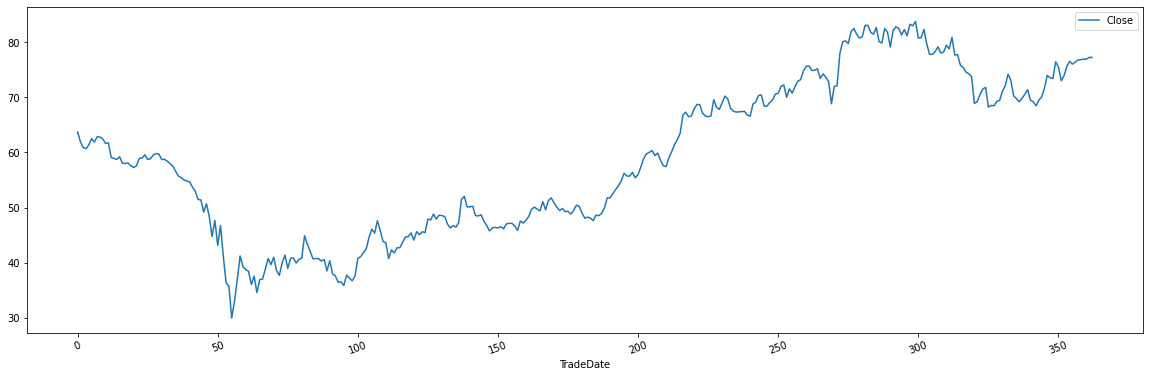

In [ ]:
# Creating a column as date
StockData['TradeDate']=StockData.index
 
# Plotting the stock prices
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

In [ ]:
# Extracting the closing prices of each day
FullData=StockData[['Close']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[63.700001]
 [62.009998]
 [60.91    ]
 [60.689999]
 [61.34    ]]
### After Normalization ###


array([[0.62725416],
       [0.59583563],
       [0.57538577],
       [0.57129577],
       [0.58337982]])

In [ ]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(353, 10, 1)

#### Output Data shape ####
(353, 1)


**Splitting the data into training and testing**

In [ ]:
# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(348, 10, 1)
(348, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


**Visualizing the input and output data for LSTM**

In [ ]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.62725416]
 [0.59583563]
 [0.57538577]
 [0.57129577]
 [0.58337982]
 [0.60531698]
 [0.59379071]
 [0.61145191]
 [0.61070834]
 [0.60420151]] -- [0.58895704]
[[0.59583563]
 [0.57538577]
 [0.57129577]
 [0.58337982]
 [0.60531698]
 [0.59379071]
 [0.61145191]
 [0.61070834]
 [0.60420151]
 [0.58895704]] -- [0.59081618]


**Creating the Deep Learning LSTM model**

In [ ]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
70/70 [==============================] - 6s 12ms/step - loss: 0.3067
Epoch 2/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0144
Epoch 3/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0086
Epoch 4/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0076
Epoch 5/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0064
Epoch 6/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0056
Epoch 7/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0039
Epoch 8/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0050
Epoch 9/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 10/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0048
Epoch 11/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0039
Epoch 12/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0037
Epoch 13/100
70/70 [=====

**Measuring the accuracy of the model on testing** 

Accuracy: 99.60268120086488


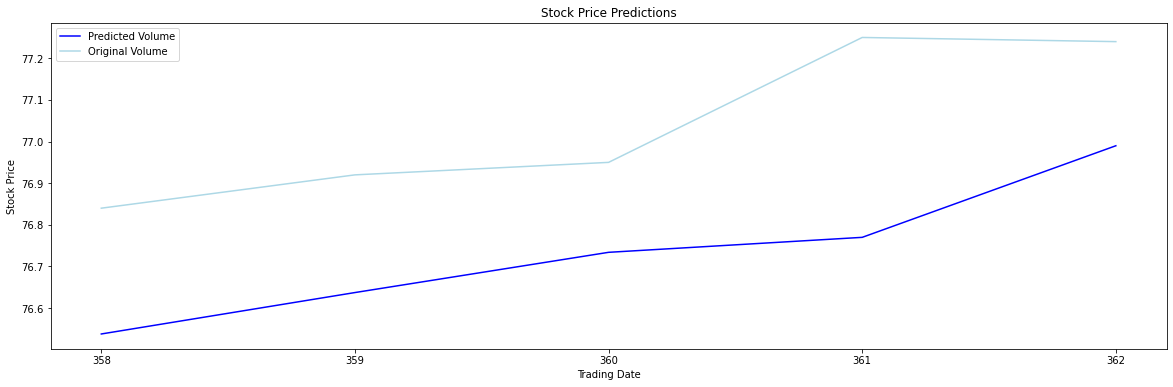

In [ ]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
# Visualising the results
import matplotlib.pyplot as plt
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

**Visualizing the predictions for full data**

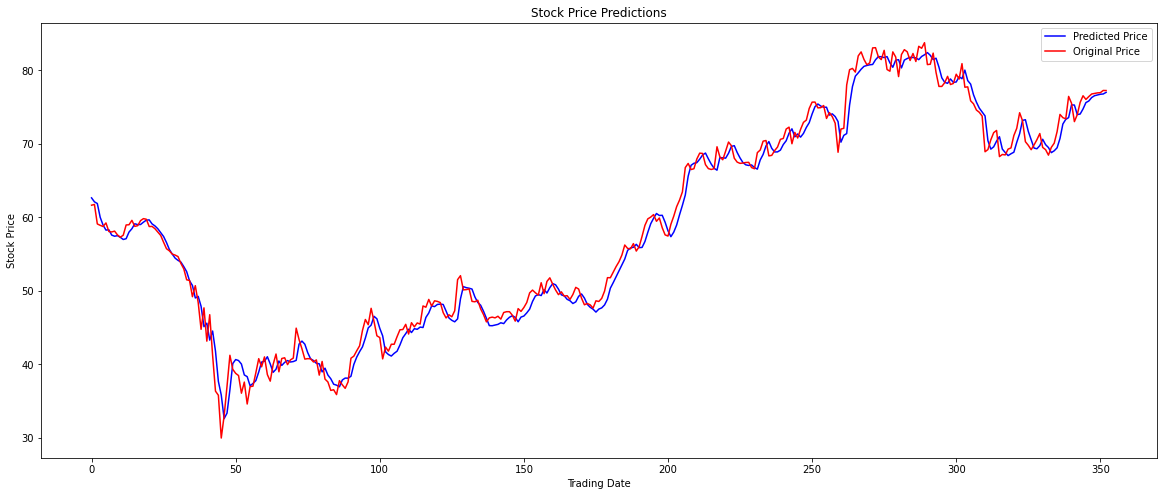

In [ ]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'red', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

**How to predict the stock price for tomorrow**

In [ ]:
# Last 10 days prices
Last10Days=np.array([1002.15, 1009.9, 1007.5, 1019.75, 975.4,
            1011.45, 1010.4, 1009,1008.25, 1017.65])
 
# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

array([[75.73873]], dtype=float32)